In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

In [12]:
data__ = pd.read_csv("section_fer2013.csv")

labels_ = data__['emotion']

features = data__.drop(['emotion','Usage'], axis=1, inplace=False)

features

temp_list = []

for i in features['pixels']:
    temp_list.append(i.split())
    
features.drop('pixels',axis=1,inplace=True)

features['pixels'] = pd.Series(temp_list)

In [15]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(features,labels_,test_size = 0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=0)

In [68]:
def df_to_tensor(X_in, im_dim):
    
    list_of_2d_arrays = []
    
    
    
    for image in X_in['pixels']:
        pixel_array = []
        
        for pixel in image:
            pixel_array.append(int(pixel))
        
        pixel_array = [pixel_array[x:x+im_dim] for x in range(0,len(pixel_array),im_dim)]
        
        
        
        list_of_2d_arrays.append(pixel_array)
        
    np_arr =  np.array(list_of_2d_arrays)
    
    #print(np_arr.shape)
    
    return np_arr.reshape(np_arr.shape[0], 48, 48, 1)

In [69]:
train_tensors = df_to_tensor(X_train,48).astype('float32')/255
valid_tensors = df_to_tensor(X_val,48).astype('float32')/255
test_tensors = df_to_tensor(X_test,48).astype('float32')/255

train_targets = np.array(pd.get_dummies(y_train))
valid_targets = np.array(pd.get_dummies(y_val))
test_targets = np.array(pd.get_dummies(y_test))


In [101]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential




### TODO: Define your architecture.
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu'))

model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu'))

model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu'))

model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1, activation='relu'))
model.add(Dense(7, activation='softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_87 (Conv2D)           (None, 48, 48, 32)        160       
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 24, 24, 64)        8256      
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 12, 12, 128)       32896     
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 6, 6, 128)         0         
__________

In [102]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [103]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 5

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 9599 samples, validate on 2400 samples
Epoch 1/5
9599/9599 [==============================] - 57s 6ms/step - loss: 1.9007 - acc: 0.2466 - val_loss: 1.8696 - val_acc: 0.2429
Epoch 2/5
9599/9599 [==============================] - 55s 6ms/step - loss: 1.8477 - acc: 0.2485 - val_loss: 1.8389 - val_acc: 0.2429
Epoch 3/5
9599/9599 [==============================] - 55s 6ms/step - loss: 1.8257 - acc: 0.2485 - val_loss: 1.8273 - val_acc: 0.2429
Epoch 4/5
9599/9599 [==============================] - 865s 90ms/step - loss: 1.8166 - acc: 0.2485 - val_loss: 1.8227 - val_acc: 0.2429
Epoch 5/5
9599/9599 [==============================] - 55s 6ms/step - loss: 1.8126 - acc: 0.2485 - val_loss: 1.8213 - val_acc: 0.2429


In [99]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

In [100]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 25.8000%


### for a in range(0,5):
    print(list_of_2d_arrays[a])
    print('******')

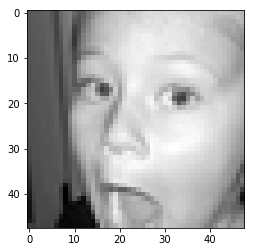

In [12]:
"""
for a in range(len(pixel_array)):
    for b in range(len(pixel_array[a])):
        pixel_array[a][b] = float(pixel_array[a][b])

im_np = np.array(pixel_array)

plt.imshow(im_np, cmap='gray')

plt.show()

"""


In [13]:
"""
lo2da = np.array(list_of_2d_arrays)
print(lo2da.shape)

input_shape = lo2da.shape
"""

(14999, 48, 48)


In [15]:
"""
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

"""

"\nmodel = Sequential()\nmodel.add(Conv2D(32, kernel_size=(3, 3),\n                 activation='relu',\n                 input_shape=input_shape))\nmodel.add(Conv2D(64, (3, 3), activation='relu'))\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\nmodel.add(Dropout(0.25))\nmodel.add(Flatten())\nmodel.add(Dense(128, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(num_classes, activation='softmax'))\n\n"